In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

DATASET_FOLDER = "../data/hubmap-organ-segmentation"
path_csv = os.path.join(DATASET_FOLDER, "train.csv")
df_train = pd.read_csv(path_csv)
display(df_train.head())

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [2]:
organ_to_label = {'kidney' : 1,
                'prostate' : 2,
                'largeintestine' : 3,
                'spleen' : 4,
                'lung' : 5}

# Explore metadata

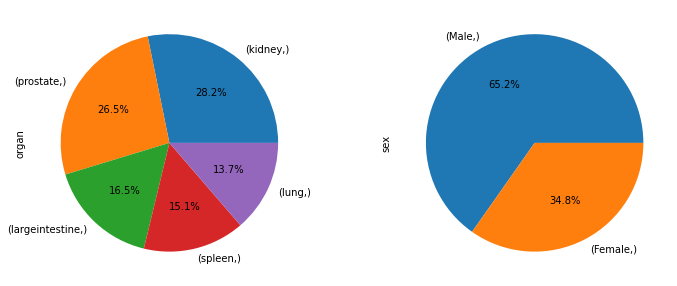

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, col in enumerate(["organ", "sex"]):
    _= df_train[[col]].value_counts().plot.pie(ax=axes[i], autopct='%1.1f%%', ylabel=col)

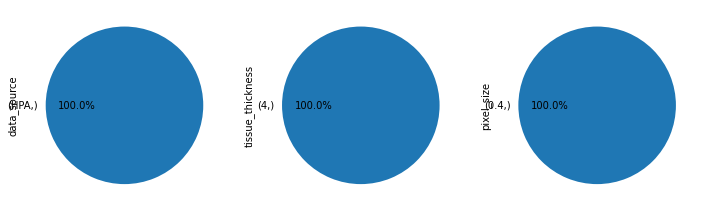

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, col in enumerate(["data_source", "tissue_thickness", "pixel_size"]):
    _= df_train[[col]].value_counts().plot.pie(ax=axes[i], autopct='%1.1f%%', ylabel=col)

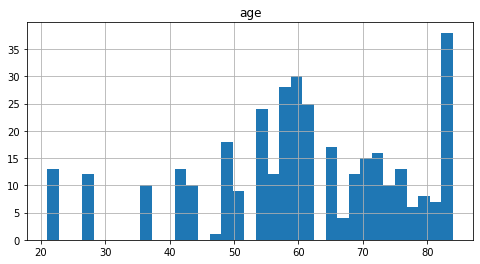

In [5]:
_= df_train[["age"]].hist(bins=35, figsize=(8, 4))

# Image sizes histograms

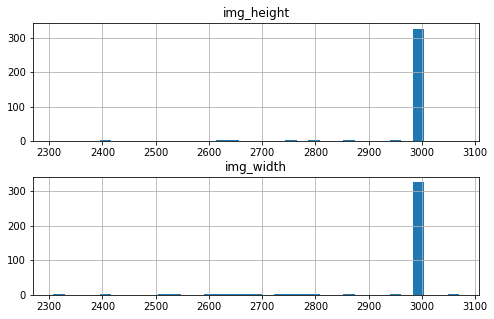

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))
for i, col in enumerate(["img_height", "img_width"]):
    _= df_train[[col]].hist(ax=axes[i], bins=35)

In [7]:
df_train.groupby(["img_height", "img_width"]).size()

img_height  img_width
2308        2308           1
2416        2416           2
2511        2511           1
2539        2539           1
2593        2593           1
2630        2630           1
2631        2631           2
2654        2654           2
2675        2675           1
2680        2680           1
2727        2727           1
2760        2760           1
2764        2764           2
2783        2783           1
2790        2790           2
2867        2867           1
2869        2869           1
2942        2942           2
3000        3000         326
3070        3070           1
dtype: int64

# Show some images

In [8]:
import numpy as np
from typing import Dict

def rle_decode(mask_rle: str, img_shape: tuple = None, organ_name=None, organ_to_label=None) -> np.ndarray:
    seq = mask_rle.split()
    starts = np.array(list(map(int, seq[0::2])))
    lengths = np.array(list(map(int, seq[1::2])))
    assert len(starts) == len(lengths)
    ends = starts + lengths
    img = np.zeros((np.product(img_shape),), dtype=np.uint8)
    for begin, end in zip(starts, ends):
        img[begin:end] = 1
    if organ_name == None:
        return img.reshape(img_shape)
    else:
        img = img.reshape(img_shape)
        val = organ_to_label[organ_name]
        img[img == 1] = val
        return img
        

def rle_encode(mask: np.ndarray, label_bg: int = 0) -> Dict[int, str]:
    """Encode mask to Run-length encoding.
    Inspiration took from: https://gist.github.com/nvictus/66627b580c13068589957d6ab0919e66
    >>> from pprint import pprint
    >>> mask = np.array([[0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    ...                  [0, 0, 0, 1, 1, 1, 2, 2, 2, 0],
    ...                  [0, 0, 0, 0, 0, 1, 3, 3, 0, 0],])
    >>> pprint(rle_encode(mask))
    {1: '1 5 13 3 25 1', 2: '16 3', 3: '26 2'}
    """
    vec = mask.flatten()
    nb = len(vec)
    where = np.flatnonzero
    starts = np.r_[0, where(~np.isclose(vec[1:], vec[:-1], equal_nan=True)) + 1]
    lengths = np.diff(np.r_[starts, nb])
    values = vec[starts]
    assert len(starts) == len(lengths) == len(values)
    rle = {}
    for start, length, val in zip(starts, lengths, values):
        if val == label_bg:
            continue
        rle[val] = rle.get(val, []) + [str(start), length]
    # post-processing
    rle = {lb: " ".join(map(str, id_lens)) for lb, id_lens in rle.items()}
    return rle

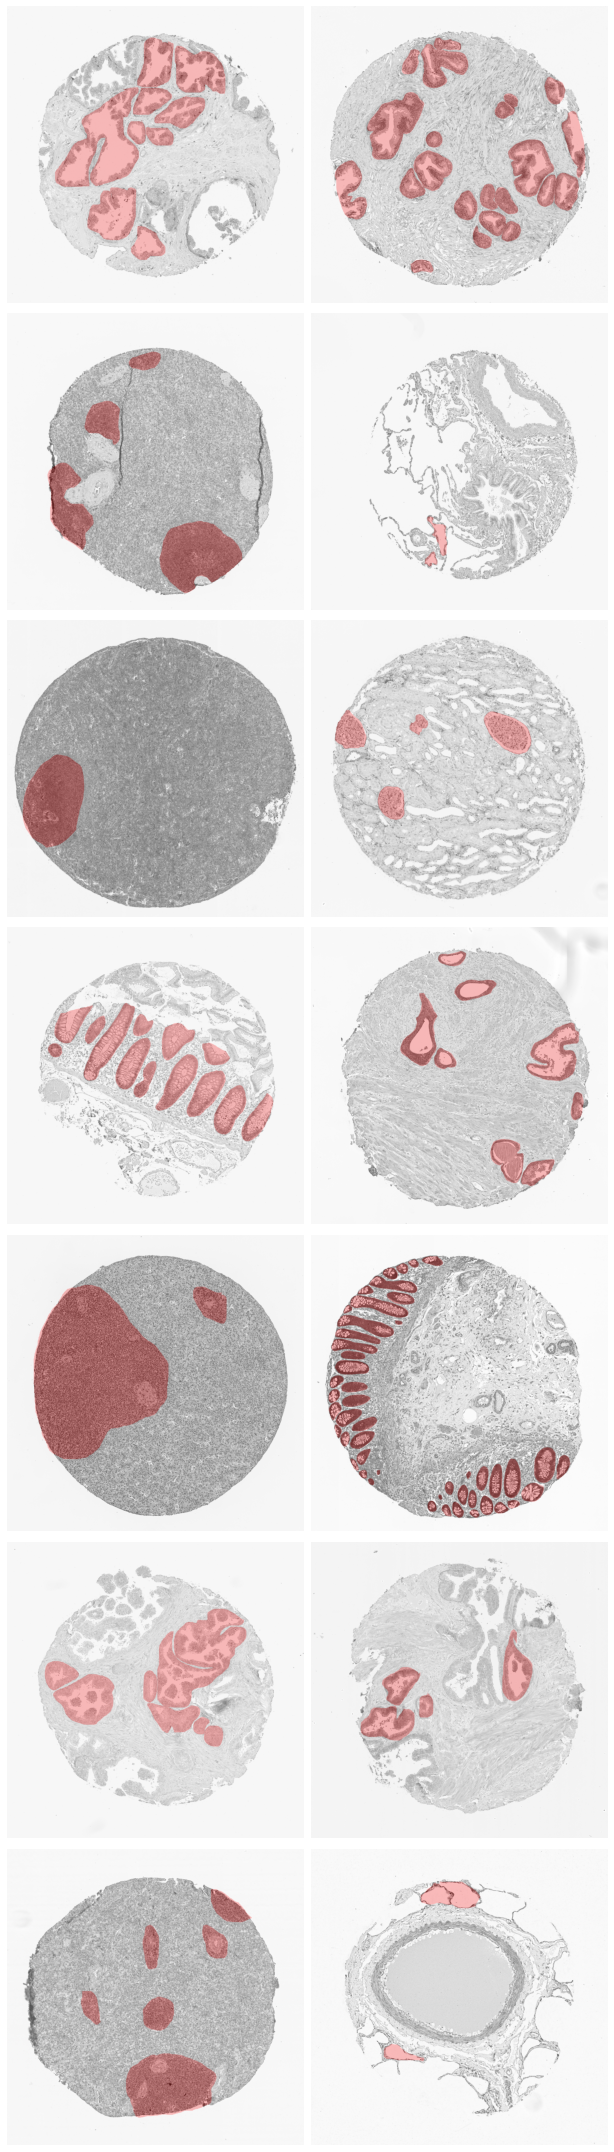

In [9]:
import matplotlib.pyplot as plt
from skimage import color

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(9, 30))
for i, row in df_train.iterrows():
    if i >= 14:
        break
    img = plt.imread(os.path.join(DATASET_FOLDER, "train_images", f"{row['id']}.tiff"))
    mask = rle_decode(row['rle'], img_shape=(row["img_height"], row["img_width"]), organ_name=row['organ'], organ_to_label=organ_to_label).T
    axes[i // 2, i % 2].imshow(color.label2rgb(mask, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
    axes[i // 2, i % 2].set_axis_off()
    rle = rle_encode(mask.T)
    assert row['rle'] == rle[organ_to_label[row['organ']]]
fig.tight_layout()

# Export masks

In [10]:
! mkdir -p ../data/hubmap-organ-segmentation/train_masks_multi_label

from PIL import Image
from tqdm.auto import tqdm

for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
    mask = rle_decode(row['rle'], img_shape=(row["img_height"], row["img_width"]), organ_name=row['organ'], organ_to_label=organ_to_label).T
    segm_path = os.path.join("../data/hubmap-organ-segmentation/train_masks_multi_label", f"{row['id']}.png")
    Image.fromarray(mask).save(segm_path)

  0%|          | 0/351 [00:00<?, ?it/s]

[0 2]
[0 2]
[0 4]
[0 5]


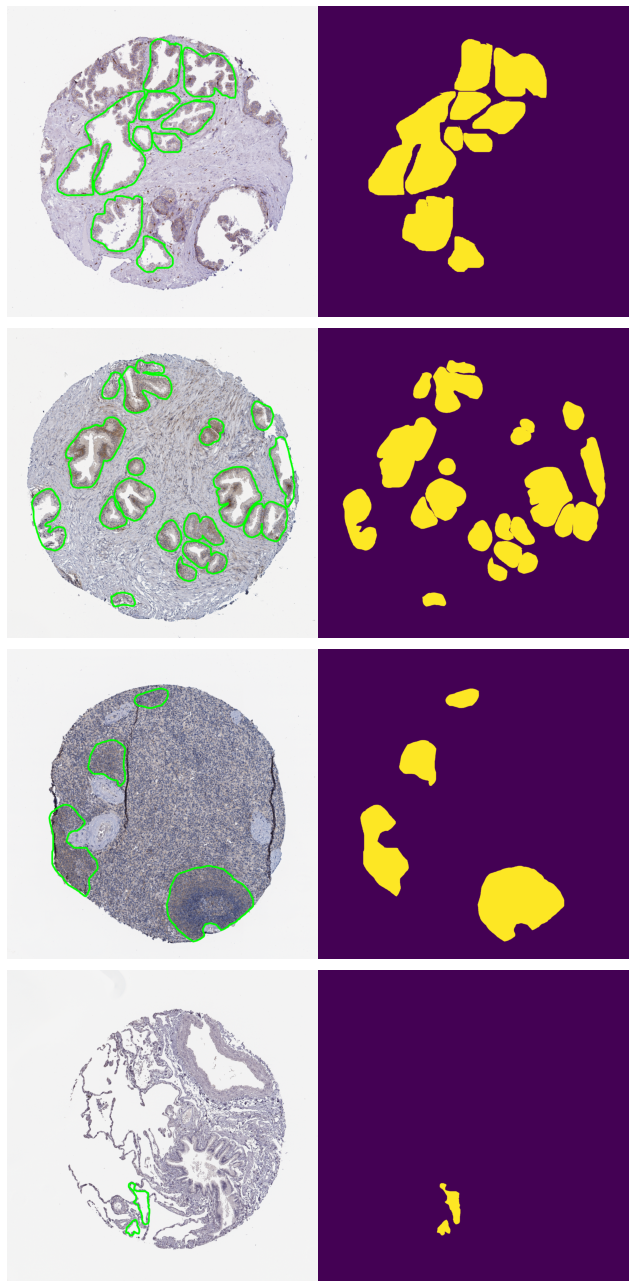

In [11]:
import cv2

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9, 18))
for i, row in df_train.iterrows():
    if i >= 4:
        break
    img = plt.imread(os.path.join(DATASET_FOLDER, "train_images", f"{row['id']}.tiff"))
    mask = np.array(Image.open(os.path.join("../data/hubmap-organ-segmentation/train_masks_multi_label", f"{row['id']}.png")))
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for j, _ in enumerate(contours):
        cv2.drawContours(img, contours, j, color=(0, 255, 0), thickness=15)
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(mask, interpolation='antialiased', interpolation_stage='rgba')
    print(np.unique(mask[:]))
    # axes[i // 2, i % 2].imshow(color.label2rgb(mask.T, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
    axes[i, 0].set_axis_off()
    axes[i, 1].set_axis_off()
fig.tight_layout()

# Make split

In [20]:
all_image_files = glob.glob("../data/hubmap-organ-segmentation/train_images/*")
patients = [os.path.basename(_).split("_")[0] for _ in all_image_files]
! mkdir -p ../data/hubmap-organ-segmentation/splits

from sklearn.model_selection import GroupKFold

split = list(GroupKFold(5).split(patients, groups = patients))

for fold, (train_idx, valid_idx) in enumerate(split):
    with open(f"../data/hubmap-organ-segmentation/splits/fold_{fold}.txt", "w") as f:
        for idx in train_idx:
            f.write(os.path.basename(all_image_files[idx]).split('.')[0] + "\n")
    with open(f"../data/hubmap-organ-segmentation/splits/holdout_{fold}.txt", "w") as f:
        for idx in valid_idx:
            f.write(os.path.basename(all_image_files[idx]).split('.')[0] + "\n")